### CS 268 - HW2
* Name: Berkay Guler
* Department: NetSys 

## Problem 1a)
### A - Steepest Descent Algorithm:
##### I am using the steepest descent method to perform the gradient descent instead of choosing a constant or scheduled step size. Below is the algoritm steps with notation similar to that of *K&W Algorithms for Optimization*.

1) Choose a descent direction $d^{(k)}$ the opposite of the $\nabla{f(x^{(k)})}$ where $x^{(k)}$ is the $k$th design point. $$ d^{(k)} = -\frac{\nabla{f(x^{(k)})}}{\lVert\nabla{f(x^{(k)})}\rVert}$$
2) Perform a line search along the descent to direction to find the optimum value of step size $\alpha$.
$$\alpha^{(k)}= \underset{\alpha}{argmin} f(x^{(k)}+\alpha d^{(k)})$$
3) Descent by step size.
$$ x^{(k+1)} = x^{(k)}+\alpha^{(k)} d^{(k)}$$
4) Repeat steps 1, 2 and 3 until convergence

**Note:** I used the golden search implementation from the HW1 to solve for the optimization problem in step 2.

In [1]:
using LinearAlgebra
# The abstraction template from Algorithm 5.1 of K&W
abstract type DescentMethod end

mutable struct GradientDescent <: DescentMethod
    α
end

steepest_init!(M::GradientDescent, f, ∇f, x) = M

function steepest_step!(M::GradientDescent, f, ∇f, x)
    # source code taken (but modified) from: K&W Algorithms for Optimization page 71
    # one iteration of gradient descent algorithm
    g = ∇f(x)
    # normalized gradient
    d = -g / sqrt(dot(g, g))
    # finding the optimal step size
    M.α = line_search(f, x, d)
    return x + M.α*d
end


function line_search(f, x, d)
    # source code taken (but modified) from: K&W Algorithms for Optimization page 54
    # returns optimal step size by performing line search of f along d and starting at x
    objective = α -> f(x + α*d)
    # 1-D minimization solver 
    α = minimize(objective)
    return α
end


function minimize(
        func, initial_point=0, 
        initial_step_size=1e-2, convergence_thr=0.000000001;)
    # source code taken (but modified) from: K&W Algorithms for Optimization page 41
    # returns the value at which func attains its min value
    # optimization method used = Golden Section Search 
    # source(s) of code used = K&W Algorithms for Optimization, page 41
    
    a, b = bracket_minimum(func, initial_point, s=initial_step_size, k=2.0)
    ρ = φ - 1
    d = ρ * b  + (1 - ρ)*a
    yd = func(d)
    x_estimate_curr = (a + b)/2
    x_estimate_prev = x_estimate_curr + convergence_thr + 0.0001  
    eval_count = 1
    
    while abs(x_estimate_curr - x_estimate_prev) > convergence_thr
        c = ρ*a + (1 - ρ)*b 
        yc = func(c)
        if yc < yd
            b, d, yd = d, c, yc
        else
            a, b = b, c
        end
        x_estimate_prev = x_estimate_curr
        x_estimate_curr = (a + b)/2
        eval_count += 1
    end
    # return x_estimate_curr, abs(x_estimate_curr - x_estimate_prev), eval_count
    return x_estimate_curr
end


function bracket_minimum(fnc, x=0; s=1e-4, k=2.0)
    # source code taken from: K&W Algorithms for Optimization page 36
    # returns an interval in which fnc has a minimum
    # source(s) of code used = K&W Algorithms for Optimization, page 36
    a, ya = x, fnc(x)
    b, yb = a + s, fnc(a + s) 
    if yb > ya
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    end
    while true
        c, yc = b + s, fnc(b + s) 
        if yc > yb
            return a < c ? (a, c) : (c, a)
        end
        a, ya, b, yb = b, yb, c, yc
        s *= k
    end
end

bracket_minimum (generic function with 2 methods)

### B - Defining Test Functions and Their Derivatives:
* The quadratic and non-quadratic test functions for this assignment are polynomials and their gradient can be analythically computed.
* Using the approach employed for Rosenbrock's Function, I have created a 10-D function using summations of Booth's Functions. I also cross checked my gradient functions using ForwardDiff package.

1) 10-D Booth's Function:
$$ f(x) = \sum_{i=1}^{9} {[(x_i + 2x_{i+1}-7)^2 + (2x_i + x_{i+1}-5)^2]}$$
2) 10-D Rosenbrock Function:
$$ f(x) = \sum_{i=1}^{9} {[(a-x_i)^2+b(x_{i+1}-x_i^2)^2]}$$


In [2]:
# 10-D Rosenbrock Test Function
function rosenbrock_10D(x, a=1, b=1)
    summation = 0
    for i in 1:9
        summation += ((a - x[i])^2 + b*(x[i+1]-x[i]^2)^2)
    end
    return summation
end

# rosenbrock gradient function 
function ∇rosenbrock_10D(x, a=1, b=1)
    gradient_vector = []
    
    for i in 1:10
        if i == 1
            df_di = (-2*(a-x[1]) + 2*b*(x[2]-x[1]^2)*-2*x[1])
        elseif i == 10
            df_di = 2*b*(x[10]-x[9]^2)
        else
            df_di = (-2*(a-x[i]) + 2*b*(x[i+1]-x[i]^2)*-2*x[i]) + 2*b*(x[i]-x[i-1]^2) 
        end
        append!(gradient_vector, df_di)
    end
    return gradient_vector
end

# quadractic function
function booths_10D(x)
    summation = 0
    for i in 1:9
        summation += ((x[i] + 2*x[i+1] - 7)^2 + (2*x[i] + x[i+1] - 5)^2)
    end
    return summation
end

# gradient of quadratic test function
function ∇booths_10D(x)
    gradient_vector = []
    
    for i in 1:10
        if i == 1
            df_di = 2*(x[1]+2*x[2]-7) + 4*(2*x[1] + x[2] - 5)
        elseif i == 10
            df_di = 4*(x[9] + 2*x[10] - 7) + 2*(2*x[9] + x[10] - 5) 
        else
            df_di = 2*(x[i]+2*x[i+1]-7) +
                4*(2*x[i] + x[i+1] - 5) +
                4*(x[i-1] + 2*x[i] - 7) +
                2*(2*x[i-1] + x[i] - 5) 
        end
        append!(gradient_vector, df_di)
    end
    return gradient_vector
end

∇booths_10D (generic function with 1 method)

In [3]:
# verifying gradients
using ForwardDiff
x = [i/5 for i in 1:10]
gradient_manual = ∇rosenbrock_10D(x)
gradient_auto = ForwardDiff.gradient(rosenbrock_10D, x)
# make sure the gradient function works fine
@assert sum((gradient_manual - gradient_auto).^2) < 1e-10
gradient_manual = ∇booths_10D(x)
gradient_auto = ForwardDiff.gradient(booths_10D, x)
# make sure the gradient function works fine
@assert sum((gradient_manual - gradient_auto).^2) < 1e-10

### C - Gradient Descent Loop and Generating Test Points:
##### The gradient descent algorithm runs until the convergence criterion is met. The L2 distance is used as the convergence criterion.
$$\lVert x^{k+1}-x^k \rVert < \epsilon$$

In [4]:
# for some predefined constants
using Base.MathConstants

function steepest_gradient_descent(M, f, ∇f, x)
    # initialize and descent once
    M = steepest_init!(M, f, ∇f, x)
    x_current = x
    x_next = steepest_step!(M, f, ∇f, x_current)
    descent_count = 1
    # loop until convergence criterion met
    while sqrt(sum((x_next - x_current).^2)) > 0.00000001
        x_current = x_next
        x_next = steepest_step!(M, f, ∇f, x_current)
        descent_count += 1
    end
    return x_next, descent_count, sqrt(sum((x_next - x_current).^2))
end


function sample_exp_uniform_ndim(num_samples=100, ndim=10, range=10)
    # returns 10-D test points
    columns = []
    for i in 1:ndim
        # sample num_samples numbers from [-range, range]
        x = range*(rand(num_samples)) .* rand((-1, 1), num_samples)
        # raise to the power of e and select a random sign
        y = e.^x .* rand((-1, 1), 100)
        append!(columns, [y])
    end
    return hcat(columns...)
end

sample_exp_uniform_ndim (generic function with 4 methods)

### D - Statistics:
##### The gradient descent algorithm is tested with 100 starting points. Absolute error, number of function evaluation, last value of the convergence measure, and the elapsed time are reported with mean and standard deviation. 100 test points are selected based on the formula from HW1. Each test point $x=(x_1, x_2, ..., x_{10})$ is selected as follows.
$$Y_i∼Uniform(-a,a)$$ $$X_i = \pm e^{Y_i}$$

**Note:** $a=4$ is used since larger values result in the algorithm to run for a very long time (especially for nesterov momentum). 

In [5]:
using Optim
using Statistics
using TypedTables
a = 4
# rosenbrock
rb_samples = sample_exp_uniform_ndim(100, 10, a)
# solve for optimal value using Optim package
rb_res = optimize(rosenbrock_10D, rb_samples[1,:], LBFGS())
rb_gt_min_x = Optim.minimizer(rb_res)
rb_gt_min_f = rosenbrock_10D(rb_gt_min_x)

# quadratic
bt_samples = sample_exp_uniform_ndim(100, 10, a)
# solve for optimal value using Optim package
bt_res = optimize(booths_10D, bt_samples[1,:], LBFGS())
bt_gt_min_x = Optim.minimizer(bt_res)
bt_gt_min_f = booths_10D(bt_gt_min_x)

zip_object = zip(
    (rb_samples, bt_samples), 
    (rb_gt_min_f, bt_gt_min_f),
    (rosenbrock_10D, booths_10D),
    (∇rosenbrock_10D, ∇booths_10D)
)

mean_error_col = []
mean_desc_count_col = []
mean_conv_measure_col = []
mean_elapsed_time_col = []
std_error_col = []
std_desc_count_col = []
std_conv_measure_col = []
std_elapsed_time_col = []

for (samples, gt_min_f, f, ∇f) in zip_object  
    
    absolute_error_arr = []
    descent_count_arr = []
    convergence_measure_arr = []
    elapsed_time_arr = []
    
    for i in 1:size(samples)[1]
        tic = time()
        M = GradientDescent(1)  # initial α value does not matter
        min_x, num_descent, conv_measure = steepest_gradient_descent(
            M, f, ∇f, samples[i,:]
        )
        elapsed_time = (time() - tic) * 1000
        min_f = f(min_x)
        append!(absolute_error_arr, abs(min_f - gt_min_f))
        append!(descent_count_arr, num_descent)
        append!(convergence_measure_arr, conv_measure)
        append!(elapsed_time_arr, elapsed_time)
    end
    
    append!(mean_error_col, mean(absolute_error_arr))
    append!(mean_desc_count_col, mean(descent_count_arr))
    append!(mean_conv_measure_col, mean(convergence_measure_arr))
    append!(mean_elapsed_time_col, mean(elapsed_time_arr))
    append!(std_error_col, std(absolute_error_arr))
    append!(std_desc_count_col, std(descent_count_arr))
    append!(std_conv_measure_col, std(convergence_measure_arr))
    append!(std_elapsed_time_col, std(elapsed_time_arr))
end

In [6]:
mean_table = Table(
    Func = ["10-D Rosenbrock", "10-D Booth's Function"], 
    AbsoluteError = mean_error_col,
    Convergence = mean_conv_measure_col, NumDescents = mean_desc_count_col,
    ElapsedTime = mean_elapsed_time_col)

Table with 5 columns and 2 rows:
     Func                   AbsoluteError  Convergence  NumDescents  ElapsedTime
   ┌────────────────────────────────────────────────────────────────────────────
 1 │ 10-D Rosenbrock        5.75491e-15    9.13667e-9   465.73       4.06751
 2 │ 10-D Booth's Function  3.37508e-15    5.45723e-9   92.1         0.945463

In [7]:
std_table = Table(
    Func = ["10-D Rosenbrock", "10-D Booth's Function"], 
    AbsoluteError = std_error_col,
    Convergence = std_conv_measure_col, NumDescents = std_desc_count_col,
    ElapsedTime = std_elapsed_time_col)

Table with 5 columns and 2 rows:
     Func                   AbsoluteError  Convergence  NumDescents  ElapsedTime
   ┌────────────────────────────────────────────────────────────────────────────
 1 │ 10-D Rosenbrock        5.63653e-16    2.86367e-10  502.756      16.6135
 2 │ 10-D Booth's Function  3.40146e-15    1.66478e-9   6.61877      4.01318

## Problem 1b)
### A - Comparing Statisctics with Conjugate Gradient Descent:
Compared to steepest gradient descent, conjugate gradient descent chooses the descent direction to be the combination of the previous descent and the current gradient direction. The other steps are the same as shown below.

**Algorithm**:
1) Start with steepest descent $$d^{(1)} = -g^{(1)} = -\nabla{f(x^{(1)})}$$ or obtain the descent direction if previous descent direction exists $$ d^{(k)}=-g^{(k)}+\beta^{(k)}d^{(k-1)}$$ where $\beta (k)=max(0, \frac{g^{(k)}\top (g^{(k)}-g^{(k-1)})}{g^{(k-1)}\top g^{(k-1)}})$
2) Use line search to determine the optimal step size $\alpha$ $$\alpha^k= \underset{\alpha}{argmin} f(x^k+\alpha d^k)$$
3) Descent by step size.
$$ x^{k+1} = x^k+\alpha^k d^k$$
4) Repeat steps 1, 2 and 3 until convergence

In [8]:
mutable struct ConjugateGradientDescent <: DescentMethod
    # source code taken from: K&W Algorithms for Optimization page 74
    d
    g
end

function conjugate_init!(M::ConjugateGradientDescent, f, ∇f, x)
    # source code taken from: K&W Algorithms for Optimization page 74
    M.g = ∇f(x)
    M.d = -M.g
    return M
end

function conjugate_step!(M::ConjugateGradientDescent, f, ∇f, x)
    # source code taken (but modified) from: K&W Algorithms for Optimization page 74
    # previous gradient and direction
    d, g = M.d, M.g
    α = line_search(f, x, d)
    # obtain new design point
    x′ = x + α*d
    # compute current gradient and direction
    g′ = ∇f(x′)
    β = max(0, dot(g′, g′ - g)/(g⋅g))
    d′ = -g′ + β*d
    M.d, M.g = d′, g′
    return x′
end

function conjugate_gradient_descent(M, f, ∇f, x)
    M = conjugate_init!(M, f, ∇f, x)
    x_current = x
    x_next = conjugate_step!(M, f, ∇f, x_current)
    descent_count = 1  # we already descended once
    while sqrt(sum((x_next - x_current).^2)) > 0.00000001
        x_current = x_next
        x_next = conjugate_step!(M, f, ∇f, x_current)
        descent_count += 1
    end
    return x_next, descent_count, sqrt(sum((x_next - x_current).^2))
end

conjugate_gradient_descent (generic function with 1 method)

In [9]:
# rosenbrock
rb_samples = sample_exp_uniform_ndim(100, 10, a)
rb_res = optimize(rosenbrock_10D, rb_samples[1,:], LBFGS())
rb_gt_min_x = Optim.minimizer(rb_res)
rb_gt_min_f = rosenbrock_10D(rb_gt_min_x)

# quadratic
bt_samples = sample_exp_uniform_ndim(100, 10, a)
bt_res = optimize(booths_10D, bt_samples[1,:], LBFGS())
bt_gt_min_x = Optim.minimizer(bt_res)
bt_gt_min_f = booths_10D(bt_gt_min_x)

zip_object = zip(
    (rb_samples, bt_samples), 
    (rb_gt_min_f, bt_gt_min_f),
    (rosenbrock_10D, booths_10D),
    (∇rosenbrock_10D, ∇booths_10D)
)

mean_error_col = []
mean_desc_count_col = []
mean_conv_measure_col = []
mean_elapsed_time_col = []
std_error_col = []
std_desc_count_col = []
std_conv_measure_col = []
std_elapsed_time_col = []

for (samples, gt_min_f, f, ∇f) in zip_object  
    
    absolute_error_arr = []
    descent_count_arr = []
    convergence_measure_arr = []
    elapsed_time_arr = []
    for i in 1:size(samples)[1]
        tic = time()
        M = ConjugateGradientDescent(1, 1)
        min_x, num_descent, conv_measure = conjugate_gradient_descent(
            M, f, ∇f, samples[i,:])
        elapsed_time = (time() - tic) * 1000
        min_f = f(min_x)
        append!(absolute_error_arr, abs(min_f - gt_min_f))
        append!(descent_count_arr, num_descent)
        append!(convergence_measure_arr, conv_measure)
        append!(elapsed_time_arr, elapsed_time)
    end
    
    append!(mean_error_col, mean(absolute_error_arr))
    append!(mean_desc_count_col, mean(descent_count_arr))
    append!(mean_conv_measure_col, mean(convergence_measure_arr))
    append!(mean_elapsed_time_col, mean(elapsed_time_arr))
    append!(std_error_col, std(absolute_error_arr))
    append!(std_desc_count_col, std(descent_count_arr))
    append!(std_conv_measure_col, std(convergence_measure_arr))
    append!(std_elapsed_time_col, std(elapsed_time_arr))
end

In [10]:
mean_table = Table(
    Func = ["10-D Rosenbrock", "10-D Booth's Function"],
    AbsoluteError = mean_error_col,
    Convergence = mean_conv_measure_col, 
    NumDescents = mean_desc_count_col,
    ElapsedTime = mean_elapsed_time_col)

Table with 5 columns and 2 rows:
     Func                   AbsoluteError  Convergence  NumDescents  ElapsedTime
   ┌────────────────────────────────────────────────────────────────────────────
 1 │ 10-D Rosenbrock        2.2823e-16     6.59959e-9   54.29        1.75264
 2 │ 10-D Booth's Function  5.8975e-15     2.62179e-9   12.97        0.313373

In [11]:
std_table = Table(
    Func = ["10-D Rosenbrock", "10-D Booth's Function"],
    AbsoluteError = std_error_col,
    Convergence = std_conv_measure_col,
    NumDescents = std_desc_count_col,
    ElapsedTime = std_elapsed_time_col)

Table with 5 columns and 2 rows:
     Func                   AbsoluteError  Convergence  NumDescents  ElapsedTime
   ┌────────────────────────────────────────────────────────────────────────────
 1 │ 10-D Rosenbrock        3.10431e-16    2.27302e-9   14.1766      13.0223
 2 │ 10-D Booth's Function  3.24199e-15    2.43018e-9   0.758188     1.94585

**Comparison:** Conjugate gradient method converges in much shorter time compared to gradient descent. Also variance of elapsed time and number of descents are lower for conjugate gradient descent, which shows that it is more robust to different initializations. The final value of the convergence measure and absolute error seems to be very similar between two methods. As for the comparison between functions, the 10-D Rosenbrock Function seems to be more difficult to optimize. I suspect this is because of the narrow valleys that provide noisy gradient directions during descent steps. 

## Problem 2)
### A - Advanced Descent Method: 
I am using Nesterov Momentum method as the advanced descent method for this assignment. This algorithm maintains a constant learning rate and accumulates information from previous descends using an exponentially decaying momentum term. The momentum helps when the gradient information cannot guide the descent properly in existence of flat surfaces. 

**Algorithm**
1) Choose the initial momentum (descent direction) $v^{(1)}$ as the gradient at starting point $x^{(1)}$
$$ v^{(1)} = -\alpha \nabla f(x^{(0)})$$
2) Descent by the learning rate $\alpha$
$$ x^{(1)} = x^{(0)} + v^{(1)}$$
3) Update the momentum using the gradient at the projected design point and the decayed momentum from the previous descent
$$ v^{(k)} = \beta v^{(k-1)} - \alpha \nabla f(x^{(k-1)}+\beta v^{(k-1)})$$
4) Obtain the new design point
$$ x^{(k)} = x^{(k-1)} + v^{(k)} $$
5) Repeat steps 3 and 4 until convergence.

**Note:** I have experienced exploding gradient problem with larger values of $\beta$ and $\alpha$ and needed to tune them until the algorithm converges work for each starting point.

In [12]:
mutable struct NesterovMomentum <: DescentMethod
    # source code taken from: K&W Algorithms for Optimization page 76
    α # learning rate
    β # momentum decay
    v # momentum
end

function nest_mom_init!(M::NesterovMomentum, f, ∇f, x)
    # source code taken from: K&W Algorithms for Optimization page 76
    M.v = zeros(length(x))
    return M
end

function nest_mom_step!(M::NesterovMomentum, f, ∇f, x)
    # source code taken from: K&W Algorithms for Optimization page 76
    α, β, v = M.α, M.β, M.v
    v[:] = β*v - α*∇f(x + β*v)
    return x + v
end

function nesterov_momentum_descent(M, f, ∇f, x)
    M = nest_mom_init!(M, f, ∇f, x)
    x_current = x
    x_next = nest_mom_step!(M, f, ∇f, x_current)
    descent_count = 1  # we already descended once
    while sqrt(sum((x_next - x_current).^2)) > 0.00000001
        x_current = x_next
        x_next = nest_mom_step!(M, f, ∇f, x_current)
        descent_count += 1
    end
    return x_next, descent_count, sqrt(sum((x_next - x_current).^2))
end

nesterov_momentum_descent (generic function with 1 method)

### B - Collecting Statistics

In [13]:
α = 0.0001  # learning rate
β = 0.5 # momentum decay rate

# rosenbrock
rb_samples = sample_exp_uniform_ndim(100, 10, a)
rb_res = optimize(rosenbrock_10D, rb_samples[1,:], LBFGS())
rb_gt_min_x = Optim.minimizer(rb_res)
rb_gt_min_f = rosenbrock_10D(rb_gt_min_x)

# quadratic
bt_samples = sample_exp_uniform_ndim(100, 10, a)
bt_res = optimize(booths_10D, bt_samples[1,:], LBFGS())
bt_gt_min_x = Optim.minimizer(bt_res)
bt_gt_min_f = booths_10D(bt_gt_min_x)

zip_object = zip(
    (rb_samples, bt_samples), 
    (rb_gt_min_f, bt_gt_min_f),
    (rosenbrock_10D, booths_10D),
    (∇rosenbrock_10D, ∇booths_10D)
)

mean_error_col = []
mean_desc_count_col = []
mean_conv_measure_col = []
mean_elapsed_time_col = []
std_error_col = []
std_desc_count_col = []
std_conv_measure_col = []
std_elapsed_time_col = []

for (samples, gt_min_f, f, ∇f) in zip_object  
    
    absolute_error_arr = []
    descent_count_arr = []
    convergence_measure_arr = []
    elapsed_time_arr = []
    for i in 1:size(samples)[1]
        tic = time()
        M = NesterovMomentum(α, β, 0)
        min_x, num_descent, conv_measure = nesterov_momentum_descent(
            M, f, ∇f, samples[i,:])
        elapsed_time = (time() - tic) * 1000
        min_f = f(min_x)
        append!(absolute_error_arr, abs(min_f - gt_min_f))
        append!(descent_count_arr, num_descent)
        append!(convergence_measure_arr, conv_measure)
        append!(elapsed_time_arr, elapsed_time)
    end
    append!(mean_error_col, mean(absolute_error_arr))
    append!(mean_desc_count_col, mean(descent_count_arr))
    append!(mean_conv_measure_col, mean(convergence_measure_arr))
    append!(mean_elapsed_time_col, mean(elapsed_time_arr))
    append!(std_error_col, std(absolute_error_arr))
    append!(std_desc_count_col, std(descent_count_arr))
    append!(std_conv_measure_col, std(convergence_measure_arr))
    append!(std_elapsed_time_col, std(elapsed_time_arr))
end

In [14]:
mean_table = Table(
    Func = ["10-D Rosenbrock", "10-D Booth's Function"],
    AbsoluteError = mean_error_col,
    Convergence = mean_conv_measure_col,
    NumDescents = mean_desc_count_col,
    ElapsedTime = mean_elapsed_time_col)

Table with 5 columns and 2 rows:
     Func                   AbsoluteError  Convergence  NumDescents  ElapsedTime
   ┌────────────────────────────────────────────────────────────────────────────
 1 │ 10-D Rosenbrock        3.12388e-9     9.99961e-9   1.23522e5    232.91
 2 │ 10-D Booth's Function  3.54304e-10    9.99617e-9   19178.5      35.1362

In [15]:
std_table = Table(
    Func = ["10-D Rosenbrock", "10-D Booth's Function"],
    AbsoluteError = std_error_col,
    Convergence = std_conv_measure_col,
    NumDescents = std_desc_count_col,
    ElapsedTime = std_elapsed_time_col)

Table with 5 columns and 2 rows:
     Func                   AbsoluteError  Convergence  NumDescents  ElapsedTime
   ┌────────────────────────────────────────────────────────────────────────────
 1 │ 10-D Rosenbrock        2.11103e-13    2.24126e-13  43496.9      81.7914
 2 │ 10-D Booth's Function  9.60457e-12    1.84862e-12  1309.01      2.60995

**Comments:** Nesterov momentum takes much longer compared to conjugate and steepest gradient descent. In my experience with I also realized that it required tuning for optimizing the 10-D Rosenbrock Function. Without tuning, for large values of $\beta$ and $\alpha$ I had exploding gradients problem. Nesterov momentum resulted in higher absolute error rates due to dependence on selected learning rate.

# Extras

## Investigating the Effect of Decay Parameter $\beta$ on Convergence Time of Nesterov Momentum

The parameter $\beta$ determines the previous descent direction's effect on the current descent. For larger beta the descent direction is smoother in general and the descent can follow a more direct path to the minimum. As for the variance in the convergence time, larger values of $\beta$ can be interpreted as resulting in less noisier descent paths. However, one drawback of larger $\beta$ is the exploding gradient problem which may occur at different values of $\beta$ depending on the optimized function and learning rate $\alpha$. This behavior is verified empirically below.

In [16]:
α = 0.0001  # learning rate 
βs = [i*0.05 for i in 1:18]  # momentum decay rate
# rosenbrock
rb_samples = sample_exp_uniform_ndim(100, 10, a)
rb_res = optimize(rosenbrock_10D, rb_samples[1,:], LBFGS())
rb_gt_min_x = Optim.minimizer(rb_res)
rb_gt_min_f = rosenbrock_10D(rb_gt_min_x)

# quadratic
bt_samples = sample_exp_uniform_ndim(100, 10, a)
bt_res = optimize(booths_10D, bt_samples[1,:], LBFGS())
bt_gt_min_x = Optim.minimizer(bt_res)
bt_gt_min_f = booths_10D(bt_gt_min_x)

zip_object = zip(
    (rb_samples, bt_samples), 
    (rb_gt_min_f, bt_gt_min_f),
    (rosenbrock_10D, booths_10D),
    (∇rosenbrock_10D, ∇booths_10D)
)

mean_error_col = []
mean_desc_count_col = []
mean_conv_measure_col = []
mean_elapsed_time_col = []
std_error_col = []
std_desc_count_col = []
std_conv_measure_col = []
std_elapsed_time_col = []

for β in βs
    println("β=$β")
    for (samples, gt_min_f, f, ∇f) in zip_object
        absolute_error_arr = []
        descent_count_arr = []
        convergence_measure_arr = []
        elapsed_time_arr = []
        for i in 1:size(samples)[1]
            tic = time()
            M = NesterovMomentum(α, β, 0)
            min_x, num_descent, conv_measure = nesterov_momentum_descent(
                M, f, ∇f, samples[i,:])
            elapsed_time = (time() - tic) * 1000
            min_f = f(min_x)
            append!(absolute_error_arr, abs(min_f - gt_min_f))
            append!(descent_count_arr, num_descent)
            append!(convergence_measure_arr, conv_measure)
            append!(elapsed_time_arr, elapsed_time)
        end
        append!(mean_error_col, mean(absolute_error_arr))
        append!(mean_desc_count_col, mean(descent_count_arr))
        append!(mean_conv_measure_col, mean(convergence_measure_arr))
        append!(mean_elapsed_time_col, mean(elapsed_time_arr))
        append!(std_error_col, std(absolute_error_arr))
        append!(std_desc_count_col, std(descent_count_arr))
        append!(std_conv_measure_col, std(convergence_measure_arr))
        append!(std_elapsed_time_col, std(elapsed_time_arr))
    end
end

β=0.05
β=0.1
β=0.15000000000000002
β=0.2
β=0.25
β=0.30000000000000004
β=0.35000000000000003
β=0.4
β=0.45
β=0.5
β=0.55
β=0.6000000000000001
β=0.65
β=0.7000000000000001
β=0.75
β=0.8
β=0.8500000000000001
β=0.9


In [17]:
# mean and std of elapsed time for each function 
rb_mean_time_col = [mean_elapsed_time_col[i] for i in 1:length(mean_elapsed_time_col) if i % 2 == 1 ]
rb_std_time_col = [mean_elapsed_time_col[i] for i in 1:length(std_elapsed_time_col) if i % 2 == 1 ]
bt_mean_time_col = [mean_elapsed_time_col[i] for i in 1:length(mean_elapsed_time_col) if i % 2 == 0 ]
bt_std_time_col = [mean_elapsed_time_col[i] for i in 1:length(mean_elapsed_time_col) if i % 2 == 0 ]

18-element Vector{Float64}:
 61.57686233520508
 57.64702796936035
 54.36319589614868
 50.35153865814209
 47.478764057159424
 46.400933265686035
 43.42839479446411
 39.323570728302
 35.96193075180054
 32.92951583862305
 29.844670295715332
 26.848363876342773
 23.75758647918701
 20.890111923217773
 17.733514308929443
 14.171226024627686
 10.782079696655273
  7.2837233543396

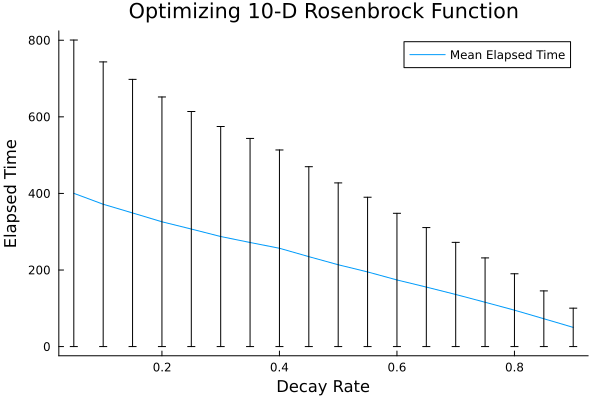

In [18]:
using Plots
plot(
    βs, rb_mean_time_col, grid=false,
    yerror=rb_std_time_col, labels="Mean Elapsed Time",
    xlabel="Decay Rate",  ylabel="Elapsed Time",
    title="Optimizing 10-D Rosenbrock Function")

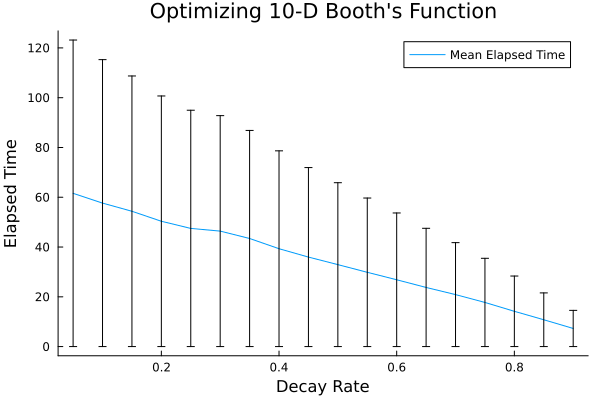

In [19]:
plot(
    βs, bt_mean_time_col, grid=false,
    yerror=bt_std_time_col, labels="Mean Elapsed Time",
    xlabel="Decay Rate",  ylabel="Elapsed Time",
    title="Optimizing 10-D Booth's Function")

## Investigating the Effect of Sampling Parameter $a$ on Convergence Time of Conjugate Gradient Descent and Gradient Descent
As $a$ takes larger values, starting points scatter over a larger area and the starting points get further away from the minimum value. Hence, I expected both the variance and mean of the convergence time to increase. This expectation is verified empirically below. Especially for Rosenbrock's function, the convergence time is highly dependent on the initialization point. On the other hand conjugate gradient method proved less sensitive to starting point compared to steepest gradient descent method.

In [20]:
as = [i for i in 1:9]

mean_error_col = []
mean_desc_count_col = []
mean_conv_measure_col = []
mean_elapsed_time_col = []
std_error_col = []
std_desc_count_col = []
std_conv_measure_col = []
std_elapsed_time_col = []

for a in as
    println("a=$a")
    # rosenbrock
    rb_samples = sample_exp_uniform_ndim(100, 10, a)
    rb_res = optimize(rosenbrock_10D, rb_samples[1,:], LBFGS())
    rb_gt_min_x = Optim.minimizer(rb_res)
    rb_gt_min_f = rosenbrock_10D(rb_gt_min_x)
    
    # quadratic
    bt_samples = sample_exp_uniform_ndim(100, 10, a)
    bt_res = optimize(booths_10D, bt_samples[1,:], LBFGS())
    bt_gt_min_x = Optim.minimizer(bt_res)
    bt_gt_min_f = booths_10D(bt_gt_min_x)
    
    zip_object = zip(
        (rb_samples, bt_samples), 
        (rb_gt_min_f, bt_gt_min_f),
        (rosenbrock_10D, booths_10D),
        (∇rosenbrock_10D, ∇booths_10D)
    )
    
    for (samples, gt_min_f, f, ∇f) in zip_object  
        
        absolute_error_arr = []
        descent_count_arr = []
        convergence_measure_arr = []
        elapsed_time_arr = []
        for i in 1:size(samples)[1]
            tic = time()
            M = ConjugateGradientDescent(1, 1)
            min_x, num_descent, conv_measure = conjugate_gradient_descent(
                M, f, ∇f, samples[i,:])
            elapsed_time = (time() - tic) * 1000
            min_f = f(min_x)
            append!(absolute_error_arr, abs(min_f - gt_min_f))
            append!(descent_count_arr, num_descent)
            append!(convergence_measure_arr, conv_measure)
            append!(elapsed_time_arr, elapsed_time)
        end
        
        append!(mean_error_col, mean(absolute_error_arr))
        append!(mean_desc_count_col, mean(descent_count_arr))
        append!(mean_conv_measure_col, mean(convergence_measure_arr))
        append!(mean_elapsed_time_col, mean(elapsed_time_arr))
        append!(std_error_col, std(absolute_error_arr))
        append!(std_desc_count_col, std(descent_count_arr))
        append!(std_conv_measure_col, std(convergence_measure_arr))
        append!(std_elapsed_time_col, std(elapsed_time_arr))
    end
end

a=1
a=2
a=3
a=4
a=5
a=6
a=7
a=8
a=9


In [21]:
# mean time and std for each function 
rb_mean_time_col = [mean_elapsed_time_col[i] for i in 1:length(mean_elapsed_time_col) if i % 2 == 1 ]
rb_std_time_col = [mean_elapsed_time_col[i] for i in 1:length(std_elapsed_time_col) if i % 2 == 1 ]
bt_mean_time_col = [mean_elapsed_time_col[i] for i in 1:length(mean_elapsed_time_col) if i % 2 == 0 ]
bt_std_time_col = [mean_elapsed_time_col[i] for i in 1:length(mean_elapsed_time_col) if i % 2 == 0 ]

9-element Vector{Float64}:
 0.0655221939086914
 0.06256580352783203
 0.08469104766845703
 0.06586074829101562
 0.08808612823486328
 0.07734060287475586
 0.09393692016601562
 0.07317066192626953
 0.07894277572631836

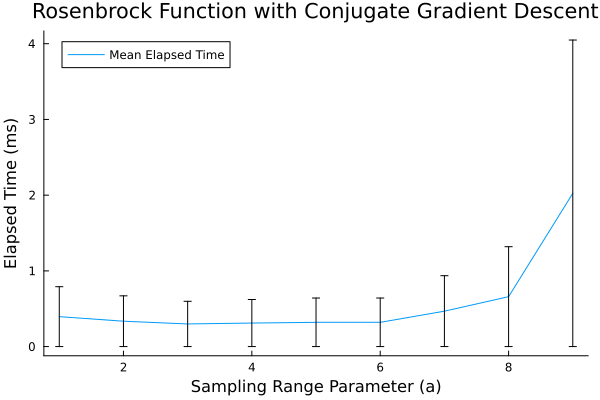

In [22]:
plot(
    as, rb_mean_time_col, grid=false,
    yerror=rb_std_time_col, labels="Mean Elapsed Time",
    xlabel="Sampling Range Parameter (a)",  
    ylabel="Elapsed Time (ms)",
    title="Rosenbrock Function with Conjugate Gradient Descent")

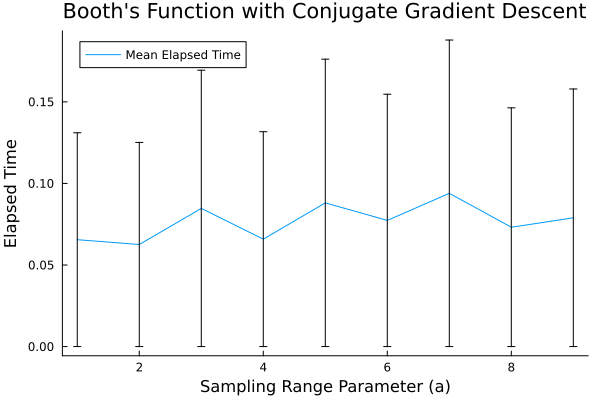

In [23]:
plot(
    as, bt_mean_time_col, grid=false,
    yerror=bt_std_time_col,
    labels="Mean Elapsed Time",
    xlabel="Sampling Range Parameter (a)",
    ylabel="Elapsed Time",
    title="Booth's Function with Conjugate Gradient Descent")

In [24]:
as = [i for i in 1:8]

mean_error_col = []
mean_desc_count_col = []
mean_conv_measure_col = []
mean_elapsed_time_col = []
std_error_col = []
std_desc_count_col = []
std_conv_measure_col = []
std_elapsed_time_col = []

for a in as
    println("a=$a")
    # rosenbrock
    rb_samples = sample_exp_uniform_ndim(100, 10, a)
    rb_res = optimize(rosenbrock_10D, rb_samples[1,:], LBFGS())
    rb_gt_min_x = Optim.minimizer(rb_res)
    rb_gt_min_f = rosenbrock_10D(rb_gt_min_x)
    
    # quadratic
    bt_samples = sample_exp_uniform_ndim(100, 10, a)
    bt_res = optimize(booths_10D, bt_samples[1,:], LBFGS())
    bt_gt_min_x = Optim.minimizer(bt_res)
    bt_gt_min_f = booths_10D(bt_gt_min_x)
    
    zip_object = zip(
        (rb_samples, bt_samples), 
        (rb_gt_min_f, bt_gt_min_f),
        (rosenbrock_10D, booths_10D),
        (∇rosenbrock_10D, ∇booths_10D)
    )
    
    for (samples, gt_min_f, f, ∇f) in zip_object  
        
        absolute_error_arr = []
        descent_count_arr = []
        convergence_measure_arr = []
        elapsed_time_arr = []
        for i in 1:size(samples)[1]
            tic = time()
            M = GradientDescent(1)
            min_x, num_descent, conv_measure = steepest_gradient_descent(
                M, f, ∇f, samples[i,:])
            elapsed_time = (time() - tic) * 1000
            min_f = f(min_x)
            append!(absolute_error_arr, abs(min_f - gt_min_f))
            append!(descent_count_arr, num_descent)
            append!(convergence_measure_arr, conv_measure)
            append!(elapsed_time_arr, elapsed_time)
        end
        
        append!(mean_error_col, mean(absolute_error_arr))
        append!(mean_desc_count_col, mean(descent_count_arr))
        append!(mean_conv_measure_col, mean(convergence_measure_arr))
        append!(mean_elapsed_time_col, mean(elapsed_time_arr))
        append!(std_error_col, std(absolute_error_arr))
        append!(std_desc_count_col, std(descent_count_arr))
        append!(std_conv_measure_col, std(convergence_measure_arr))
        append!(std_elapsed_time_col, std(elapsed_time_arr))
    end
end

a=1
a=2
a=3
a=4
a=5
a=6
a=7
a=8


In [25]:
# mean and std of elapsed time for each function
rb_mean_time_col = [mean_elapsed_time_col[i] for i in 1:length(mean_elapsed_time_col) if i % 2 == 1 ]
rb_std_time_col = [mean_elapsed_time_col[i] for i in 1:length(std_elapsed_time_col) if i % 2 == 1 ]
bt_mean_time_col = [mean_elapsed_time_col[i] for i in 1:length(mean_elapsed_time_col) if i % 2 == 0 ]
bt_std_time_col = [mean_elapsed_time_col[i] for i in 1:length(mean_elapsed_time_col) if i % 2 == 0 ]

8-element Vector{Float64}:
 0.3629612922668457
 0.3714275360107422
 0.39110422134399414
 0.38645267486572266
 0.4142951965332031
 0.4560661315917969
 0.4697847366333008
 0.47939300537109375

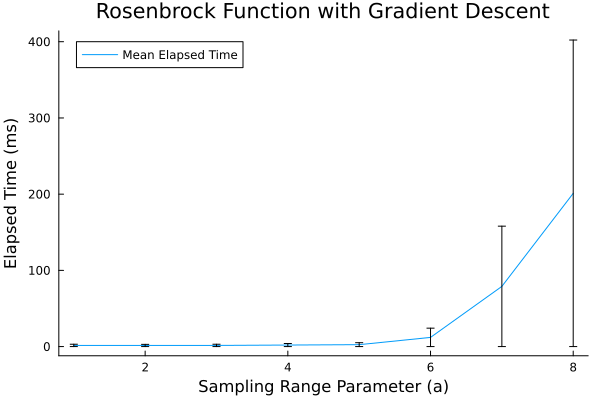

In [26]:
plot(
    as, rb_mean_time_col, grid=false,
    yerror=rb_std_time_col, 
    labels="Mean Elapsed Time",
    xlabel="Sampling Range Parameter (a)",
    ylabel="Elapsed Time (ms)",
    title="Rosenbrock Function with Gradient Descent")

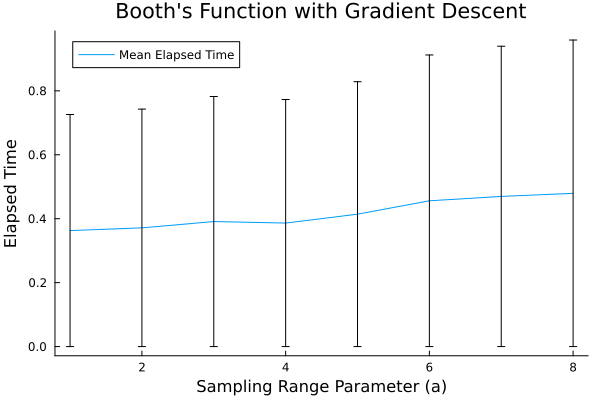

In [27]:
plot(
    as, bt_mean_time_col, grid=false,
    yerror=bt_std_time_col, labels="Mean Elapsed Time",
    xlabel="Sampling Range Parameter (a)",
    ylabel="Elapsed Time",
    title="Booth's Function with Gradient Descent")